In [81]:
import sys
sys.path.append("..")

# basics
import numpy as np
import scipy
import matplotlib.pyplot as plt
import copy
import qutip.floquet as floq
import qutip

# custom stuff
import system.from_higher_basis_truncation_tunable_full_cosine as system
import utils.solver as solver
import pulse.tukey as tukey
import utils.expectation_values as expv
import utils.graph as graph
import utils.saver as saver

# parallel utils
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor

pass

fidelity 0.9990087877079039


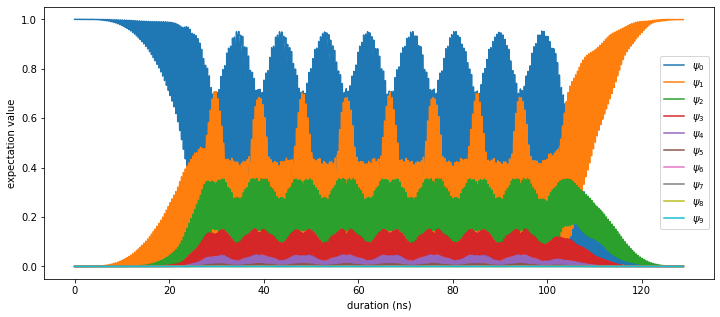

In [82]:
# Start with a pulse applied to our system

# Already found decent params...
# fidelity = 0.9990697298060399
# offset = 0.3898644953695122 
# duration = 128.81398725509644
# amplitude = 2 * 2.5 * pi
# ramp_coef = 0.5

t_max = 128.81398725509644
offset = 0.3898644953695122 
freq = system.first_energy_spacing/3 - offset
durations = np.arange(0, t_max, (2*np.pi)/(freq*20))
amp = 2 * 2.5 * np.pi
ramp_coef = 0.5

tukey.setup(amp, freq, ramp_coef, durations)

s = solver.time_evolve(system.H0, system.H1, tukey.pulse_func, durations, system.starting_state, pbar=True)

graph.graph_solution(s, system)
print("fidelity", expv.expectation_value(s.final_state, system.target_state))


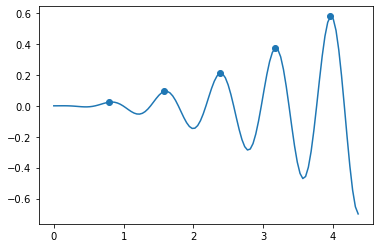

In [83]:
# Create list of points at peaks of pulse

dur_points = np.arange(0, t_max, (2*np.pi)/(freq))[::1]
dur_points = dur_points[1:-1]
pulse = tukey.get_pulse(durations)
num_of_points = 111
num_of_durPoints = 5

plt.plot(durations[:num_of_points], pulse[:num_of_points])
plt.scatter(dur_points[:num_of_durPoints], tukey.get_pulse(dur_points)[:num_of_durPoints])


In [139]:
# Sorting algorithm to determine ordering of floquet kets
# Here we are just trying to keep the states as similar as possible as time evolves

_old_sorted_kets = []

def initial_sort_kets(kets, debug=False):
    sorted_kets = list(np.zeros(len(kets)))
    sorted_indices = []
    used_idxs = set()
    unused_kets = []
    for i in range(len(kets)):
        ket = kets[i]
        idx = np.argmax(ket.full())
        sorted_indices.append(idx)
        if not idx in used_idxs:
            used_idxs.add(idx)
            sorted_kets[idx] = ket
        else:
            unused_kets.append(ket)
    
    for ket in unused_kets:
        for i in range(len(sorted_kets)):
            if sorted_kets[i] == 0:
                sorted_kets[i] = ket
                break

    if debug:
        print(sorted_indices)
        # print(sorted_kets[0])
    
    return np.array(sorted_kets)

def sort_kets1(kets, old_kets, debug=False):
    if len(old_kets) == 0:
        sk = initial_sort_kets(kets, debug)
        return sk # pass by value is obviously needed here
    else:
        new_sort_indices = []
        for ket in kets:
            most_similar_index = -1
            min_diff = 1000
            for i in range(0, len(old_kets)):
                if not i in new_sort_indices:
                    old_ket = old_kets[i]
                    diff = 0
                    for row_index in range(0, len(ket.full())):
                        diff += np.abs(ket[row_index] - old_ket[row_index])
                    if diff < min_diff:
                        min_diff = diff
                        most_similar_index = i
            new_sort_indices.append(most_similar_index)
        
        if(debug):
            print(new_sort_indices)
            # print(kets[new_sort_indices[0]])

        new_sorted_kets = np.array(old_kets)[new_sort_indices]
        _old_sorted_kets = new_sorted_kets
        return np.array(new_sorted_kets)

In [110]:
# Here we order them according to their correspondence to the fock basis


_sort_indices = []

def sort_kets2(kets, debug=False):
    sorted_kets = list(np.zeros(len(kets)))
    sorted_indices = []
    used_idxs = set()
    unused_kets = []
    for i in range(len(kets)):
        ket = kets[i]
        idx = np.argmax(ket.full())
        sorted_indices.append(idx)
        if not idx in used_idxs:
            used_idxs.add(idx)
            sorted_kets[idx] = ket
        else:
            unused_kets.append(ket)
    
    for ket in unused_kets:
        for i in range(len(sorted_kets)):
            if sorted_kets[i] == 0:
                sorted_kets[i] = ket
                break

    if debug:
        print(sorted_indices)
    
    return np.array(sorted_kets)

In [124]:
# Here we order them according to their correspondence to the fock basis
# We break ties by looking at similarity
# WIP

_sort_indices = []

def sort_kets3(kets, debug=False):
    sorted_kets = list(np.zeros(len(kets)))
    sorted_indices = []
    idxs_per_ket = []
    for i in range(len(kets)):
        ket = kets[i]
        idxs_per_ket.append(np.argsort(ket.full())) # a list of which fock states are most corresponded to
        
    for i in range(len(kets)):
        ket_indices_wanting_this_i = []
        for j in range(len(idxs_per_ket)):
            if(idxs_per_ket[j][0] == i):
                ket_indices_wanting_this_i.append(j)
        if len(ket_indices_wanting_this_i) == 0:
            # we might have a problem here
            print("reee")
            pass
        elif len(ket_indices_wanting_this_i) == 1:
            # everything is great!
            sorted_kets[i] = ket_indices_wanting_this_i[0]
        elif len(ket_indices_wanting_this_i) > 1:
            # we need to sort these too
            while len(ket_indices_wanting_this_i) > 1:
                # kick the least likely one off to its next highest index

    if debug:
        print(sorted_indices)
    
    return np.array(kets)[sorted_indices]

In [189]:
kets = []
for dur in dur_points:
    dur_amp = tukey.pulse_func(dur)
    def steady(t, args=None):
        return dur_amp * np.cos(freq * t)
    H = [system.H0, [system.H1, steady]]

    floquet_kets, quasi_energies = floq.floquet_modes(H, (2*np.pi)/freq)
    kets.append(floquet_kets)

sorted_kets = [np.array(kets[0]).reshape((10,10))]

for i in range(1, len(dur_points)):
    reshaped_ket = np.array(kets[i]).reshape((10,10))
    m = np.abs(np.dot( (sorted_kets[-1]), np.transpose(reshaped_ket)  ))**2
    row_ind, col_ind = sp.optimize.linear_sum_assignment(1-m)
    # print(col_ind)
    sorted_kets.append( reshaped_ket[col_ind] )

In [192]:
len(dur_points)

161

In [186]:
np.array(sorted_kets[1])[:3]

array([[-3.57069823e-03+1.27942333e-11j, -5.70447835e-04+3.80896811e-09j,
        -1.06269071e-01+4.93018375e-07j,  1.44817061e-02-1.45352251e-08j,
         9.55574516e-01+0.00000000e+00j, -1.17759990e-02-2.34493614e-07j,
         2.57757686e-01-1.40619636e-05j, -4.44392636e-03+1.02432810e-07j,
         9.35979855e-02-6.38780312e-06j, -1.84477625e-03+2.01077384e-07j],
       [ 1.01440179e-03-5.94685888e-08j, -1.15948523e-04-8.70947142e-09j,
        -2.12663717e-03-1.55731783e-06j, -3.04982816e-03+2.37662033e-07j,
        -2.75578956e-01+1.57064315e-05j,  1.98863611e-02-2.48189704e-07j,
         8.90176745e-01+0.00000000e+00j, -8.16390453e-03-1.34453949e-07j,
         3.62145523e-01-3.65705190e-06j, -3.90370106e-03+3.44570136e-07j],
       [-1.69220537e-02-3.93198829e-09j,  7.09636056e-03+1.14408986e-09j,
         9.94112035e-01+0.00000000e+00j, -8.59736218e-03+5.39954557e-11j,
         1.01557209e-01-3.25211507e-09j, -1.41498172e-03-4.93432919e-09j,
         3.11739351e-02-5.18657717e-

In [187]:
np.array(sorted_kets[2])[:3]

array([[-3.57226207e-03+2.03662508e-11j, -1.27863211e-03+7.78862349e-09j,
        -1.05957230e-01+4.49530006e-07j,  3.24913405e-02-2.95899609e-08j,
         9.54745515e-01+0.00000000e+00j, -2.64157498e-02-4.80573040e-07j,
         2.58006464e-01-1.28361360e-05j, -9.97444019e-03+2.09236597e-07j,
         9.37135050e-02-5.83510799e-06j, -4.14065742e-03+4.14997691e-07j],
       [ 1.01185177e-03-5.43843347e-08j, -2.60375241e-04-1.78549463e-08j,
        -2.17575498e-03-1.41814429e-06j, -6.83781728e-03+4.87478071e-07j,
        -2.74868155e-01+1.43414568e-05j,  4.46134708e-02-5.08304415e-07j,
         8.89284219e-01+0.00000000e+00j, -1.83125744e-02-2.79450424e-07j,
         3.62168538e-01-3.34956141e-06j, -8.75959711e-03+7.18844152e-07j],
       [-1.68583944e-02-3.66340383e-09j,  1.59200027e-02+2.37640880e-09j,
         9.93837124e-01+0.00000000e+00j, -1.92918737e-02+1.01325965e-10j,
         1.01730606e-01-3.49023989e-09j, -3.17712721e-03-1.02277529e-08j,
         3.12163343e-02-4.81660097e-

In [184]:
np.array(kets[2]).reshape((10,10))[:3]

array([[-3.57226207e-03+2.03662508e-11j, -1.27863211e-03+7.78862349e-09j,
        -1.05957230e-01+4.49530006e-07j,  3.24913405e-02-2.95899609e-08j,
         9.54745515e-01+0.00000000e+00j, -2.64157498e-02-4.80573040e-07j,
         2.58006464e-01-1.28361360e-05j, -9.97444019e-03+2.09236597e-07j,
         9.37135050e-02-5.83510799e-06j, -4.14065742e-03+4.14997691e-07j],
       [ 1.01185177e-03-5.43843347e-08j, -2.60375241e-04-1.78549463e-08j,
        -2.17575498e-03-1.41814429e-06j, -6.83781728e-03+4.87478071e-07j,
        -2.74868155e-01+1.43414568e-05j,  4.46134708e-02-5.08304415e-07j,
         8.89284219e-01+0.00000000e+00j, -1.83125744e-02-2.79450424e-07j,
         3.62168538e-01-3.34956141e-06j, -8.75959711e-03+7.18844152e-07j],
       [ 9.85427391e-03+1.98436806e-09j,  9.98506466e-01+0.00000000e+00j,
        -1.46610374e-02-2.16593224e-09j,  4.95300296e-02-7.73997855e-10j,
        -1.38121927e-03+5.96970083e-10j,  1.45544343e-02+9.02016002e-09j,
        -4.41093205e-04+1.86731992e-

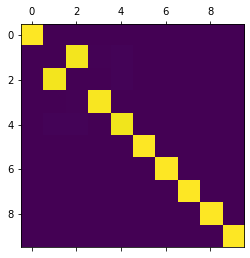

In [161]:
import scipy as sp


m = np.abs(np.dot( np.transpose(np.array(kets[1]).reshape((10,10))), np.array(kets[2]).reshape((10,10))  ))**2

plt.matshow(m)

row_ind, col_ind = sp.optimize.linear_sum_assignment(1-m)

In [164]:
col_ind

array([0, 2, 1, 3, 4, 5, 6, 7, 8, 9])

In [125]:
# utility functions 


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if np.amin(np.abs(array - value)) > 1e-12:
        print("error, duration does not exactly exist!", value, array[idx])
    return idx

def overlap(state1, state2):
    return (np.transpose(np.matrix(state1.full())) * np.matrix(state2.full())).item()

In [140]:
overlaps = []
old_kets = [[]]
kets = []
for dur in dur_points:
    dur_amp = tukey.pulse_func(dur)
    def steady(t, args=None):
        return dur_amp * np.cos(freq * t)
    H = [system.H0, [system.H1, steady]]

    floquet_kets, quasi_energies = floq.floquet_modes(H, (2*np.pi)/freq)
    kets.append(floquet_kets)

    # DEBUGGING HERE
    # sorted_floquet_kets = sort_kets1(floquet_kets, old_kets[-1], debug=False)
    # old_kets.append(sorted_floquet_kets)

    # index_of_dur = find_nearest(durations, dur)
    # overlaps_at_this_dur = []
    # sorted_floquet_kets = sorted_floquet_kets.reshape((10,10))
    # for floquet_ket in sorted_floquet_kets:
    #     if type(floquet_ket) == np.float64:
    #         print(floquet_ket)
    #         overlaps_at_this_dur.append(0)
    #         continue
    #     o = qutip.expect(qutip.ket2dm(s.states[index_of_dur]), qutip.Qobj(floquet_ket))
    #     # o = overlap(s.states[index_of_dur], floquet_ket)
    #     overlaps_at_this_dur.append(o)
    # overlaps.append(np.array(overlaps_at_this_dur))

overlaps = np.transpose(np.array(overlaps))

In [213]:
overlaps = []
for i in range(len(dur_points)):
    ket = sorted_kets[i]
    dur = dur_points[i]
    index_of_dur = find_nearest(durations, dur)
    overlaps_at_this_dur = []
    for k in ket:
        # o = qutip.expect(qutip.ket2dm(s.states[index_of_dur]), qutip.Qobj(k))
        o = overlap(s.states[index_of_dur], qutip.Qobj(k))
        overlaps_at_this_dur.append(o)
    overlaps.append(np.array(overlaps_at_this_dur))

overlaps = np.transpose(np.array(overlaps))

In [210]:
overlaps = np.transpose(overlaps)

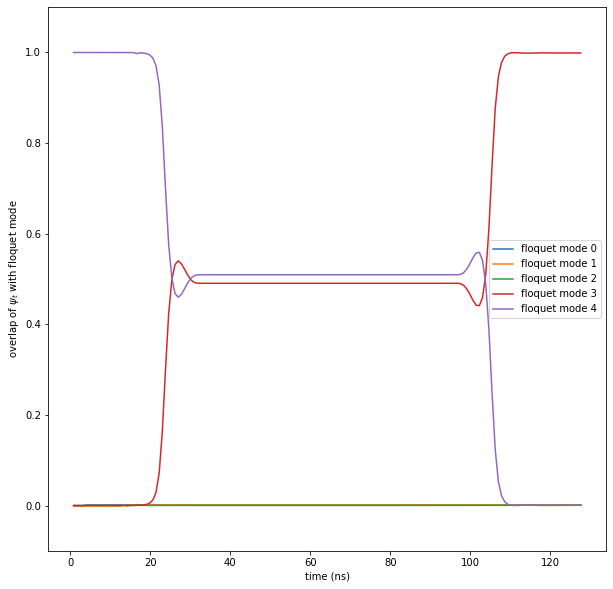

In [211]:
plt.figure(figsize=(10,10))
for i in range(0, len(overlaps)-5):
    o = overlaps[i]
    plt.plot(dur_points, o, label=r'floquet mode %i' % i)
# plt.plot(dur_points, overlaps, label=labeled_overlaps)
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel(r'overlap of $\psi_t$ with floquet mode')
plt.ylim((-0.1, 1.1))
plt.show()

In [ ]:
# I know we mentioned needing to make sure phases were all the same but it seems like that is taken care of since the numbers pan out, but maybe for overlap I am missing that

In [203]:
np.array(overlaps).shape

(10, 161)

(-0.00012203977296716041+2.9666266700776376e-05j)
(0.00012031726090989968+0.00022619356717006067j)
(0.0002855853016102182-0.00026862804408397446j)
(-0.00045321704288882493-0.00027191470874835086j)
(-0.0001739456760382119+0.000636938319199676j)
(0.0007866087285841743+5.174986677527751e-06j)
(-0.0002096687354876879-0.0008901758836004418j)
(-0.0009541322190696586+0.0004545265302646591j)
(0.0007272346879960304+0.0009885270528925266j)
(0.0010009738458528138-0.0010291990705904419j)
(-0.0013570194956909177-0.0010074738492348045j)
(-0.0010479929584171314+0.0017059071001404586j)
(0.002073477548223235+0.0011953608662363898j)
(0.0015606536300134353-0.002443196439484911j)
(-0.002729841251261899-0.002298103410598216j)
(-0.003578687330676794+0.002670258754560431j)
(0.0016631808934877523+0.005425569636700285j)
(0.007205760154168313+0.00128464642192477j)
(0.006861676617913452-0.0066885966317567595j)
(0.000182848561196742-0.012744990089287265j)
(-0.009566242114775317-0.014359065655197407j)
(-0.01993610

/var/folders/8w/jht5wjcd4kl492xz8hs9lft40000gn/T/ipykernel_96875/3400026914.py:37: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, azim=-40, elev=30)


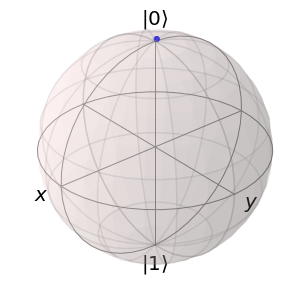

<Figure size 360x360 with 0 Axes>

In [215]:
import qutip
to_plot = []
# for dur in dur_points:
#     dur_amp = tukey.pulse_func(dur)
#     def steady(t, args=None):
#         return dur_amp * np.cos(freq * t)
#     H = [system.H0, [system.H1, steady]]

#     floquet_kets, quasi_energies = floq.floquet_modes(H, (2*np.pi)/freq)
#     sorted_floquet_kets = sort_kets(floquet_kets, debug=True)
#     to_plot.append(sorted_floquet_kets[0])
#     # computational subspace is the overlap into 0th and 1st floquet states?

xs = []
ys = []
zs = []
vecs = []
overlaps = np.transpose(overlaps)
for i in range(0, len(overlaps)):
    c0 = overlaps[i,3]
    print(c0)
    c1 = overlaps[i,4]
    xs.append( np.conjugate(c0) * c1 + c0 * np.conjugate(c1) )
    ys.append( -1j * np.conjugate(c0) * c1 + 1j * c0 * np.conjugate(c1) )
    zs.append( np.conjugate(c0) * c0 - c1 * np.conjugate(c1) )

    # xs.append(qutip.expect(qutip.ket2dm(ket), qutip.sigmax()))
    # ys.append(qutip.expect(qutip.ket2dm(ket), qutip.sigmay()))
    # zs.append(qutip.expect(qutip.ket2dm(ket), qutip.sigmaz()))
    vecs.append([xs[-1], ys[-1], zs[-1]])


from matplotlib import pyplot, animation
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = Axes3D(fig, azim=-40, elev=30)
sphere = qutip.Bloch(axes=ax)

def animate(i):
    sphere.clear()
    sphere.add_points([xs[i:i+1], ys[i:i+1], zs[i:i+1]])
    sphere.make_sphere()
    return ax

def init():
    sphere.vector_color = ['r']
    return ax

ani = animation.FuncAnimation(fig, animate, np.arange(len(xs)),
                            init_func=init, blit=False, repeat=False)

ani.save('%s_bloch_sphere.mp4' % "test", fps=20)

/usr/local/Caskroom/miniforge/base/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


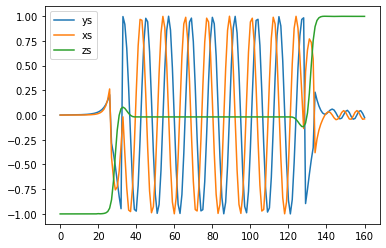

In [216]:

plt.plot(ys, label="ys")
plt.plot(xs, label="xs")
plt.plot(zs, label="zs")
plt.legend()

In [283]:
np.abs(overlaps[50][0])**2

0.8088642173951894

In [284]:
np.abs(overlaps[50][3])**2

0.19113107502264196